In [10]:
import torch
import torch.nn as nn
import gpytorch
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import pandas as pd

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, target_col, input_cols, seq_length):
        self.data = data
        self.target_col = target_col
        self.input_cols = input_cols
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[self.input_cols].iloc[idx:idx + self.seq_length].values
        y = self.data[self.target_col].iloc[idx + self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [14]:
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [15]:
# df = pd.read_csv('../data_preprocessing/Merged_data/002_verwaltung.csv')
df = pd.read_csv('../data_preprocessing/Merged_data/002_verwaltung_with_holidays_indoor_person_counts.csv')

In [16]:
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y-%m-%d %H:%M:%S')
df.set_index('DateTime', inplace=True)

In [28]:
df = df.astype({'is_holiday': 'int32', 'day_of_week': 'int32', 'hour_of_day': 'int32', 'is_working_hour': 'int32'})

In [29]:
# Define the date ranges for training and test data
train_end_date = df.index.min() + pd.DateOffset(months=9)
test_start_date = train_end_date

# Split the DataFrame
train_data = df[:train_end_date]
test_data = df[test_start_date:]

# Using weather data as input features

In [18]:
# Prepare the data
input_cols = [ 'Temperature',
       'Humidity', 'Dewpoint', 'Sun Duration', 'Precipitation Height',
       'Wind Speed', 'Wind Direction']
target_col = 'heating_15min_diff'
seq_length = 4

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [23]:
# 设置似然函数
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

# 准备训练数据（将整个数据传入模型）
train_x, train_y = [], []
for inputs, targets in train_loader:
    train_x.append(inputs[:, -1, :])  # 只使用最后一个时间步的输入特征
    train_y.append(targets)
train_x = torch.cat(train_x).to(device)
train_y = torch.cat(train_y).to(device)

# 初始化模型
model = GPRegressionModel(train_x, train_y, likelihood).to(device)

# 定义边际对数似然损失和优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# 训练模型
train_losses = []
num_epochs = 100
model.train()
likelihood.train()

for epoch in range(num_epochs):
    optimizer.zero_grad()
    # 将整个训练数据传入模型
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/100], Loss: 3.7243
Epoch [2/100], Loss: 3.6964
Epoch [3/100], Loss: 3.6708
Epoch [4/100], Loss: 3.6426
Epoch [5/100], Loss: 3.6186
Epoch [6/100], Loss: 3.5916
Epoch [7/100], Loss: 3.5642
Epoch [8/100], Loss: 3.5424
Epoch [9/100], Loss: 3.5149
Epoch [10/100], Loss: 3.4900
Epoch [11/100], Loss: 3.4690
Epoch [12/100], Loss: 3.4440
Epoch [13/100], Loss: 3.4222
Epoch [14/100], Loss: 3.3987
Epoch [15/100], Loss: 3.3766
Epoch [16/100], Loss: 3.3521
Epoch [17/100], Loss: 3.3330
Epoch [18/100], Loss: 3.3122
Epoch [19/100], Loss: 3.2909
Epoch [20/100], Loss: 3.2686
Epoch [21/100], Loss: 3.2500
Epoch [22/100], Loss: 3.2306
Epoch [23/100], Loss: 3.2087
Epoch [24/100], Loss: 3.1897
Epoch [25/100], Loss: 3.1724
Epoch [26/100], Loss: 3.1554
Epoch [27/100], Loss: 3.1353
Epoch [28/100], Loss: 3.1169
Epoch [29/100], Loss: 3.0980
Epoch [30/100], Loss: 3.0804
Epoch [31/100], Loss: 3.0646
Epoch [32/100], Loss: 3.0481
Epoch [33/100], Loss: 3.0333
Epoch [34/100], Loss: 3.0164
Epoch [35/100], Loss: 3

In [25]:
# 评估模型
model.eval()
likelihood.eval()

actuals = []
predictions = []

mse_loss_fn = torch.nn.MSELoss()

with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs[:, -1, :].to(device), targets.to(device)
        
        # 获取预测结果
        observed_pred = likelihood(model(inputs))
        mean_pred = observed_pred.mean
        
        # 计算测试集损失
        loss = mse_loss_fn(mean_pred, targets)
        test_loss += loss.item()
        
        # 存储真实值和预测值
        actuals.extend(targets.cpu().numpy())
        predictions.extend(mean_pred.cpu().numpy())
        
    print(f'Test MSE Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test RMSE Loss: {np.sqrt(test_loss/len(test_loader)):.4f}')

# 评估指标
actuals = np.array(actuals)
predictions = np.array(predictions)

mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')

Test MSE Loss: 10.1184
Test RMSE Loss: 3.1809
Test MAE: 2.4449
Test R² Score: -1.0940


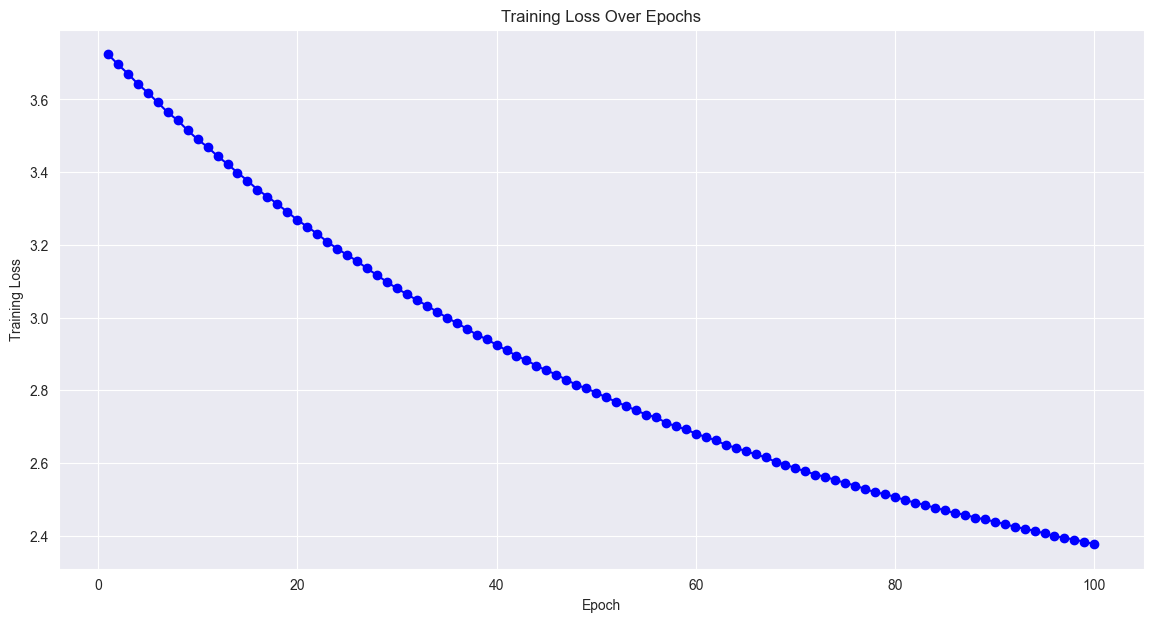

In [26]:
from matplotlib import pyplot as plt

# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

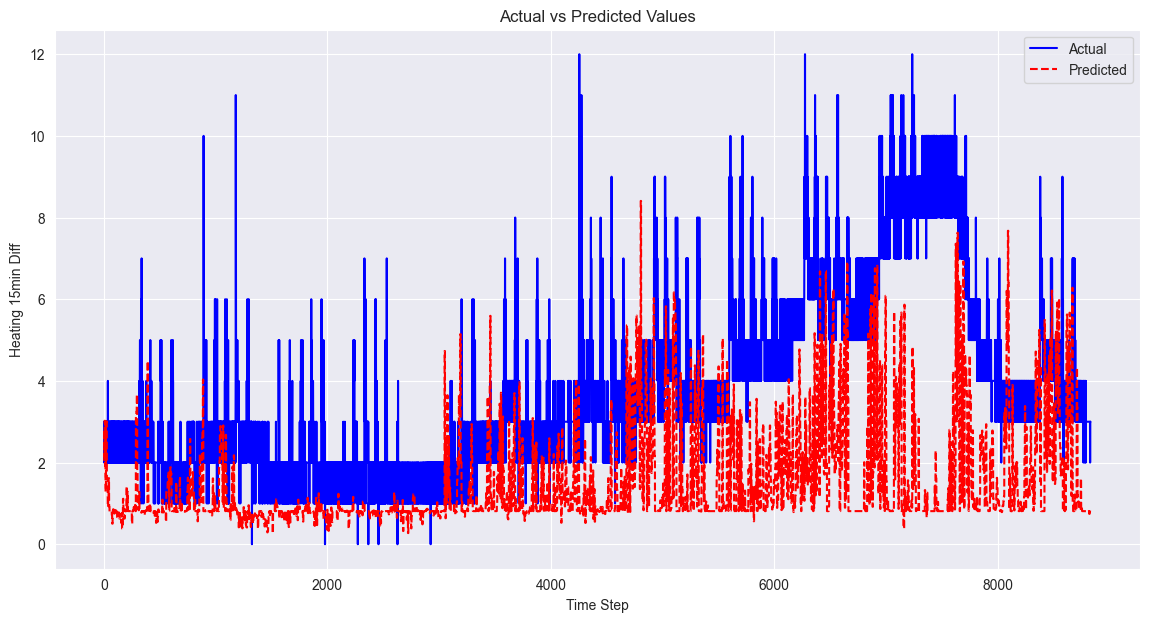

In [27]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Heating 15min Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Prepare the data
input_cols = [ 'is_holiday',
       'day_of_week', 'hour_of_day', 'is_working_hour', 'Temperature',
       'Humidity', 'Dewpoint', 'Sun Duration', 'Precipitation Height',
       'Wind Speed', 'Wind Direction']
target_col = 'heating_15min_diff'# Prepare the data
seq_length = 4

train_dataset = TimeSeriesDataset(train_data, target_col, input_cols, seq_length)
test_dataset = TimeSeriesDataset(test_data, target_col, input_cols, seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [31]:
# 设置似然函数
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

# 准备训练数据（将整个数据传入模型）
train_x, train_y = [], []
for inputs, targets in train_loader:
    train_x.append(inputs[:, -1, :])  # 只使用最后一个时间步的输入特征
    train_y.append(targets)
train_x = torch.cat(train_x).to(device)
train_y = torch.cat(train_y).to(device)

# 初始化模型
model = GPRegressionModel(train_x, train_y, likelihood).to(device)

# 定义边际对数似然损失和优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# 训练模型
train_losses = []
num_epochs = 100
model.train()
likelihood.train()

for epoch in range(num_epochs):
    optimizer.zero_grad()
    # 将整个训练数据传入模型
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()
    
    train_losses.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 3.9562
Epoch [2/100], Loss: 3.9266
Epoch [3/100], Loss: 3.9019
Epoch [4/100], Loss: 3.8746
Epoch [5/100], Loss: 3.8499
Epoch [6/100], Loss: 3.8248
Epoch [7/100], Loss: 3.7966
Epoch [8/100], Loss: 3.7720
Epoch [9/100], Loss: 3.7478
Epoch [10/100], Loss: 3.7215
Epoch [11/100], Loss: 3.6997
Epoch [12/100], Loss: 3.6768
Epoch [13/100], Loss: 3.6542
Epoch [14/100], Loss: 3.6294
Epoch [15/100], Loss: 3.6082
Epoch [16/100], Loss: 3.5844
Epoch [17/100], Loss: 3.5619
Epoch [18/100], Loss: 3.5413
Epoch [19/100], Loss: 3.5209
Epoch [20/100], Loss: 3.4980
Epoch [21/100], Loss: 3.4776
Epoch [22/100], Loss: 3.4589
Epoch [23/100], Loss: 3.4366
Epoch [24/100], Loss: 3.4207
Epoch [25/100], Loss: 3.3986
Epoch [26/100], Loss: 3.3809
Epoch [27/100], Loss: 3.3631
Epoch [28/100], Loss: 3.3458
Epoch [29/100], Loss: 3.3272
Epoch [30/100], Loss: 3.3115
Epoch [31/100], Loss: 3.2910
Epoch [32/100], Loss: 3.2748
Epoch [33/100], Loss: 3.2564
Epoch [34/100], Loss: 3.2412
Epoch [35/100], Loss: 3

In [32]:
# 评估模型
model.eval()
likelihood.eval()

actuals = []
predictions = []

mse_loss_fn = torch.nn.MSELoss()

with torch.no_grad():
    test_loss = 0
    for inputs, targets in test_loader:
        inputs, targets = inputs[:, -1, :].to(device), targets.to(device)
        
        # 获取预测结果
        observed_pred = likelihood(model(inputs))
        mean_pred = observed_pred.mean
        
        # 计算测试集损失
        loss = mse_loss_fn(mean_pred, targets)
        test_loss += loss.item()
        
        # 存储真实值和预测值
        actuals.extend(targets.cpu().numpy())
        predictions.extend(mean_pred.cpu().numpy())
        
    print(f'Test MSE Loss: {test_loss/len(test_loader):.4f}')
    print(f'Test RMSE Loss: {np.sqrt(test_loss/len(test_loader)):.4f}')

# 评估指标
actuals = np.array(actuals)
predictions = np.array(predictions)

mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f'Test MAE: {mae:.4f}')
print(f'Test R² Score: {r2:.4f}')

Test MSE Loss: 13.1924
Test RMSE Loss: 3.6321
Test MAE: 2.9078
Test R² Score: -1.7311


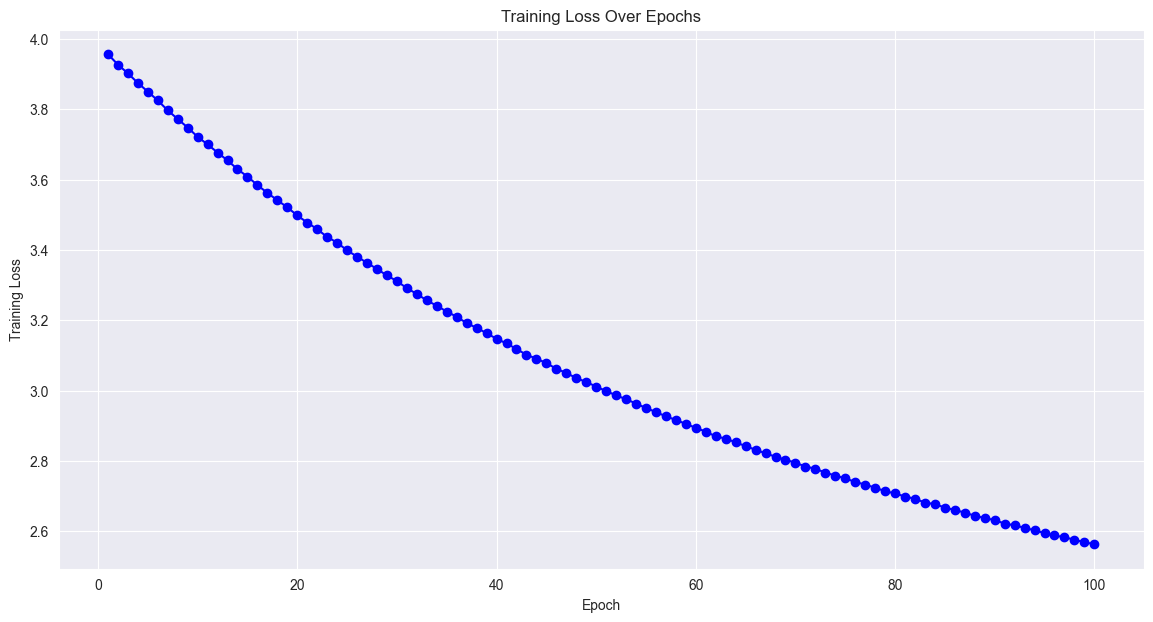

In [33]:
# Plot the training loss
plt.figure(figsize=(14, 7))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

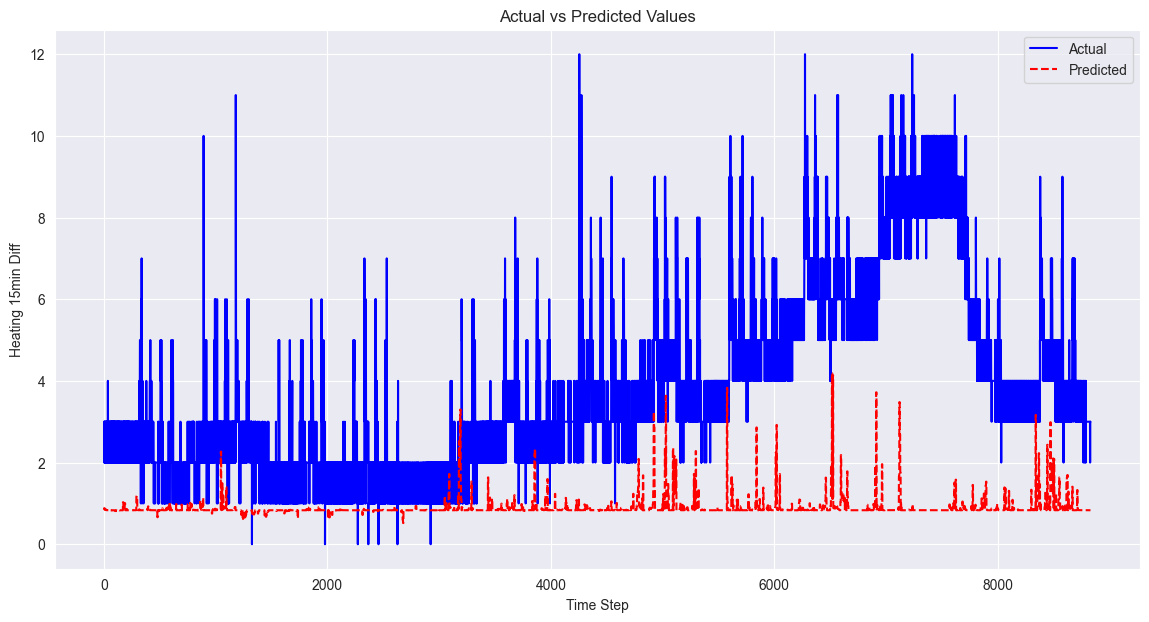

In [34]:
plt.show()
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual', color='b')
plt.plot(predictions, label='Predicted', color='r', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Heating 15min Diff')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()